Simulate Brainard-style attenuation under a simplex constraint.

We solve, for each A (here A = \u03bb A0),

$w^*(A) = argmin_{w \in \u0394}  E[(y - (w \u2299 \u03be)'x)^2 | F]$

Under the quadratic decomposition in the notes, this is equivalent (up to constants) to

$min_{w \in \u0394}   (\beta - w)'(x x')(\beta - w) + w' A w$

Let $x = \hat y_t$ and $\beta = \beta_t$ (oracle weights). Define:

$Q = x x' + A$   (PSD)

$b = (x x') \beta$

Then the constrained problem is the convex QP:

$min_{w \in \u0394}   w'Qw - 2 b'w$     (constants dropped)

We solve it with projected gradient descent onto the simplex.


We report one figure: for each $A_0$ form, plot the maximum component deviation to the limiting weights

$w_A = argmin_{w\in\u0394} w' A_0 w$ as $\lambda$ increases.

`add_ones`: $A = A_0 + \lambda J$ where $J$ is all-ones. On the simplex, $w' J w = 1$, so this term is constant and does not affect the optimizer (curves are flat).

The table summarizes the limiting HHI and the deviations at the smallest and largest $\lambda$.


In [ ]:
"""
One-shot simulation: simplex-constrained optimal weights under a general symmetric PSD A0.

We solve, for each λ and each A0 type:
    w*(λ) = argmin_{w in Δ} (β - w)'(x x')(β - w) + w'(λ A0)w
Equivalently (dropping constants):
    min_{w in Δ}  w'Qw - 2 b'w
where Q = x x' + A0 + λ I,  b = (x x')β.

Single summary criterion requested:
    max_i w_i(λ)   (the maximum weight / concentration proxy)

We generate multiple symmetric PSD A0 matrices:
    - isotropic (I)
    - diagonal heteroskedastic
    - Toeplitz correlation
    - low-rank factor + idiosyncratic
    - Wishart PSD
    - structural A0 = D(x) Σ D(x) with Σ Toeplitz correlation

Then we plot max_i w_i(λ) for all A0 types on ONE figure.
"""

import numpy as np
import matplotlib.pyplot as plt

# -----------------------------
# Simplex projection
# -----------------------------
def project_to_simplex(v, z=1.0):
    """Euclidean projection of v onto {w >= 0, sum w = z}."""
    v = np.asarray(v, dtype=float).ravel()
    n = v.size
    if n == 0:
        return v

    u = np.sort(v)[::-1]
    cssv = np.cumsum(u)
    rho = np.nonzero(u * np.arange(1, n + 1) > (cssv - z))[0]
    if rho.size == 0:
        return np.ones(n) * (z / n)
    rho = rho[-1]
    theta = (cssv[rho] - z) / (rho + 1.0)
    w = np.maximum(v - theta, 0.0)

    s = w.sum()
    if s <= 1e-15:
        return np.ones(n) * (z / n)
    return w * (z / s)


# -----------------------------
# Convex QP solver on simplex via projected gradient descent
# min_{w in Δ} w'Qw - 2 b'w, Q symmetric PSD
# -----------------------------
def solve_simplex_qp(Q, b, w0=None, max_iter=25_000, tol=1e-11):
    Q = np.asarray(Q, dtype=float)
    b = np.asarray(b, dtype=float).ravel()
    n = b.size
    assert Q.shape == (n, n)
    # Force symmetry (numerical hygiene)
    Q = 0.5 * (Q + Q.T)

    w = np.ones(n) / n if w0 is None else project_to_simplex(w0)

    # Lipschitz constant for grad: ||2Q||_2 = 2*lambda_max(Q)
    lam_max = float(np.linalg.eigvalsh(Q).max())
    step = 1.0 / (2.0 * lam_max + 1e-12)

    prev_obj = None
    for _ in range(max_iter):
        grad = 2.0 * (Q @ w) - 2.0 * b
        w_new = project_to_simplex(w - step * grad)

        obj = float(w_new @ (Q @ w_new) - 2.0 * (b @ w_new))
        if prev_obj is not None and abs(prev_obj - obj) < tol:
            w = w_new
            break
        w, prev_obj = w_new, obj

    return w


# -----------------------------
# Symmetric PSD matrix generators
# -----------------------------
def A_isotropic_I(N, rng, eps=1e-8):
    return np.eye(N) + eps * np.eye(N)

def A_diag_hetero(N, rng, eps=1e-8):
    d = rng.lognormal(mean=0.0, sigma=0.8, size=N)
    return np.diag(d) + eps * np.eye(N)

def A_toeplitz_corr(N, rng, rho=0.85, eps=1e-8):
    idx = np.arange(N)
    T = rho ** np.abs(idx[:, None] - idx[None, :])
    return T + eps * np.eye(N)

def A_lowrank_factor(N, rng, k=2, idio=0.15, eps=1e-8):
    B = rng.normal(size=(N, k))
    u = idio * rng.lognormal(mean=0.0, sigma=0.4, size=N)
    A = B @ B.T + np.diag(u)
    return 0.5 * (A + A.T) + eps * np.eye(N)

def A_wishart(N, rng, df=None, eps=1e-8):
    df = df or (N + 8)
    Z = rng.normal(size=(N, df))
    A = (Z @ Z.T) / df
    return 0.5 * (A + A.T) + eps * np.eye(N)

def A_structural_DSigmaD(N, rng, x, rho=0.7, scale=1.0, eps=1e-8):
    idx = np.arange(N)
    Sigma = (rho ** np.abs(idx[:, None] - idx[None, :])) * scale
    D = np.diag(x)
    A = D @ Sigma @ D
    return 0.5 * (A + A.T) + eps * np.eye(N)

In [33]:
# ---- User-facing knobs ----
N = 12
seed = 2
lambdas = np.logspace(-4, 4, 80)   # scale of uncertainty
# ---------------------------

rng = np.random.default_rng(seed)

# Forecast vector x and oracle beta (simplex)
x = rng.normal(size=N)
beta = rng.dirichlet(np.ones(N) * 0.4)  # somewhat concentrated oracle
xxT = np.outer(x, x)

# A0 menu (all symmetric PSD)
A0_dict = {
    "I (isotropic)":           lambda: A_isotropic_I(N, rng),
    "Diagonal (hetero)":       lambda: A_diag_hetero(N, rng),
    "Toeplitz corr":           lambda: A_toeplitz_corr(N, rng, rho=0.85),
    "Low-rank factor":         lambda: A_lowrank_factor(N, rng, k=2, idio=0.15),
    "Wishart PSD":             lambda: A_wishart(N, rng, df=N + 8),
    "D(x) Σ D(x)":             lambda: A_structural_DSigmaD(N, rng, x=x, rho=0.7, scale=1.0),
    }

# Pre-generate each A0 once (so curves are comparable and not changing with λ)
A0s = {name: maker() for name, maker in A0_dict.items()}

# Track criterion: max_i w_i(λ) for each A0 type
max_weight_curves = {name: np.zeros_like(lambdas, dtype=float) for name in A0s.keys()}

# Solve weights for each λ
for k, lam in enumerate(lambdas):
    for name, A0 in A0s.items():
        Q = xxT + A0 + lam * np.eye(N)
        b = xxT @ beta
        w = solve_simplex_qp(Q, b)
        max_weight_curves[name][k] = float(np.max(w))

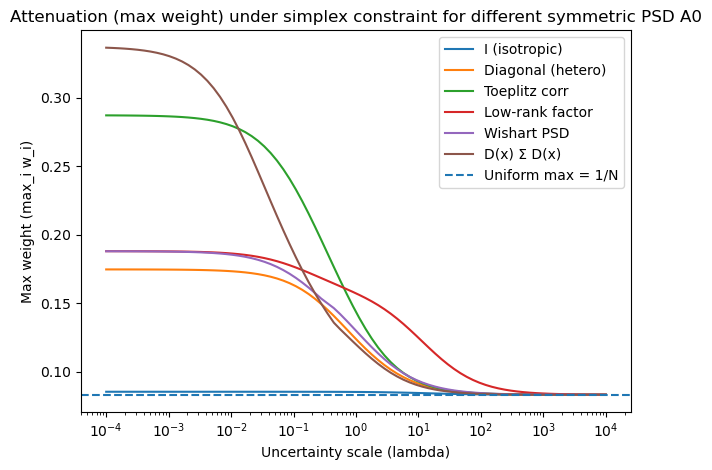

In [34]:
import matplotlib as mpl
mpl.rcParams["text.usetex"] = False

# ---- Plot all on one figure ----
plt.figure()
for name, curve in max_weight_curves.items():
    plt.semilogx(lambdas, curve, label=name)

plt.axhline(1.0 / N, linestyle="--", label="Uniform max = 1/N")
plt.xlabel("Uncertainty scale (lambda)")
plt.ylabel("Max weight (max_i w_i)")
plt.title("Attenuation (max weight) under simplex constraint for different symmetric PSD A0")
plt.legend()
plt.tight_layout()
plt.show()
